In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

# Add the parent directory of 'process' to the Python path
sys.path.append(str(Path.cwd().parent))

In [3]:
import os
import sys

storage_path = os.path.abspath("../storages")
llm_response_path = os.path.abspath("../process")
summarization_path = os.path.abspath("../summarization")
sys.path.append(storage_path)
sys.path.append(llm_response_path)
sys.path.append(summarization_path)

In [4]:
from openai import OpenAI
from dotenv import load_dotenv
from process import generate_response_without_context
import pandas as pd
from evaluation import PubmedQAEvaluation

# 1. Baseline (no context)

In [ ]:
evaluator = PubmedQAEvaluation()
records = evaluator.evaluate('/s3/misha/data_dir/MedRAG/evaluation/df_test_sampled.csv')

100%|██████████| 500/500 [04:45<00:00,  1.75it/s]


In [ ]:
df_results_no_context = pd.DataFrame(records)
df_results_no_context.to_csv('/s3/misha/data_dir/MedRAG/evaluation/results/baseline.csv', index=False)

In [12]:
df_results_no_context = pd.read_csv('/s3/misha/data_dir/MedRAG/evaluation/results/baseline.csv')
df_results_no_context['binary_label'] = df_results_no_context['label'].map({'yes': 1, 'no': 0})
df_results_no_context['binary_pred'] = df_results_no_context['pred'].map({'yes': 1, 'no': 0})

In [13]:
df_results_no_context

,QUESTION,label,pred,binary_label,binary_pred
0,Is comparison of ( 68 ) Ga DOTATATE to 18F-FDG...,yes,yes,1,1
1,Do plasma phospholipids and fatty acid composi...,yes,yes,1,1
2,Is allergic sensitization enhanced in early li...,yes,yes,1,1
3,Are serum creatinine levels significantly infl...,yes,no,1,0
4,Does modification of Knee Flexion Angle have P...,yes,yes,1,1
...,...,...,...,...,...
495,Is tamoxifen effective in good prognosis patie...,no,yes,0,1
496,Does periportal fibrosis without cirrhosis aff...,no,yes,0,1
497,Does semen treatment with progesterone and/or ...,no,yes,0,1
498,Do minor protease inhibitor mutations at basel...,no,yes,0,1


In [15]:
labels_no_context = df_results_no_context['binary_label'].values
preds_no_context = df_results_no_context['binary_pred'].values

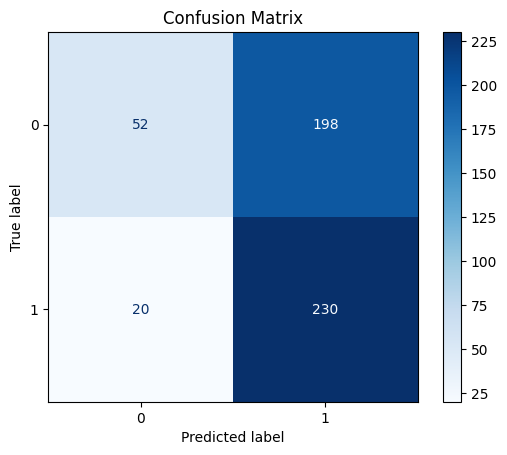

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(labels_no_context, preds_no_context)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels_no_context))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('accuracy', accuracy_score(labels_no_context, preds_no_context))
print('precision', precision_score(labels_no_context, preds_no_context))
print('recall', recall_score(labels_no_context, preds_no_context))
print('f1', f1_score(labels_no_context, preds_no_context))

accuracy 0.564
precision 0.5373831775700935
recall 0.92
f1 0.6784660766961652


# 2. QA with context

In [36]:
from pipeline import MedRAGPipeline
medrag_processor = MedRAGPipeline()

evaluator = PubmedQAEvaluation(medrag_processor)
records = evaluator.evaluate('/s3/misha/data_dir/MedRAG/evaluation/df_test_sampled.csv', is_with_context=True)

100%|██████████| 500/500 [03:25<00:00,  2.43it/s]


In [37]:
df_results_with_context = pd.DataFrame(records)
df_results_with_context.to_csv('/s3/misha/data_dir/MedRAG/evaluation/results/medrag.csv', index=False)

In [38]:
df_results_with_context = pd.read_csv('/s3/misha/data_dir/MedRAG/evaluation/results/medrag.csv')
df_results_with_context['binary_label'] = df_results_with_context['label'].map({'yes': 1, 'no': 0})
df_results_with_context['binary_pred'] = df_results_with_context['pred'].map({'yes': 1, 'no': 0})

In [39]:
labels_with_context = df_results_with_context['binary_label'].values
preds_with_context = df_results_with_context['binary_pred'].values

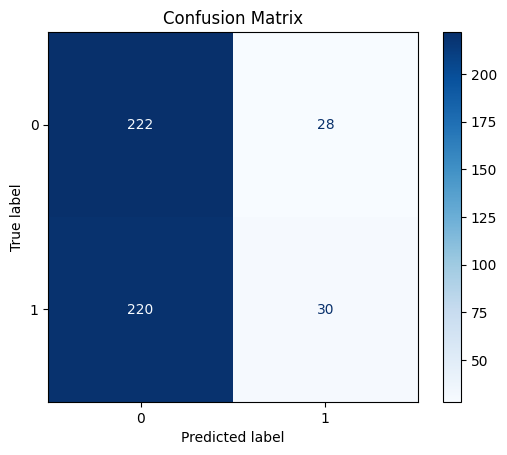

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(labels_with_context, preds_with_context)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels_no_context))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('accuracy', accuracy_score(labels_with_context, preds_with_context))
print('precision', precision_score(labels_with_context, preds_with_context))
print('recall', recall_score(labels_with_context, preds_with_context))
print('f1', f1_score(labels_with_context, preds_with_context))

accuracy 0.504
precision 0.5172413793103449
recall 0.12
f1 0.19480519480519481
